# Kepler | Star classification
*Anaelle JAFFRÉ, Guénaël ROGER*

This Jupyter Notebook is a report refering to an experimental project. It aims to discover an application of Echo State Networks (ESN) throughout a dataset of Kepler labelled time series data.

## Objective

The final objective of this project is to classify the stars of the dataset, depending on if they do have an exoplanet in their system of not.

Additionally, a transit prediction can be added as a second objective.

## Global methodology

We have time series representing measurements of their brightness over time. The ESN studies slow variations, flux drops, noise and recurring patterns in order to determine whether or not there is a transit (presence of an exoplanet). If this works, the ESN will be adapted to enable transit prediction (bonus).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

from sklearn.metrics import accuracy_score, roc_auc_score


## Dataset
Là on décrit le dataset parce qu'il est vachement bien quand-même, j'ai pas raison ? J'ai toujours raison

In [2]:
DATA_PATH = Path("../data")

train_df = pd.read_csv(DATA_PATH / "exoTrain.csv")
test_df  = pd.read_csv(DATA_PATH / "exoTest.csv")

On analyse rapidement le dataset.

In [ ]:
train_df.shape, test_df.shape # type: ignore

train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


Y'a beaucoup de données, enfin pour moi 5000 c'est beaucoup. Je sais pas si c'est vraiment beaucoup.

Après que dire des float... ?

### Séparation X/y

Par convention, en colonne 0 on a les labels, et le reste c'est les séries temporelles.

In [ ]:
y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values

y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values


#### Déséquilibre des classes

In [5]:
pd.Series(y_train).value_counts(normalize=True)

1    0.992727
2    0.007273
Name: proportion, dtype: float64

Stats globales

In [6]:
X_train.mean(), X_train.std()

(np.float64(130.41674038757165), np.float64(22072.212527378146))

##### Visualization

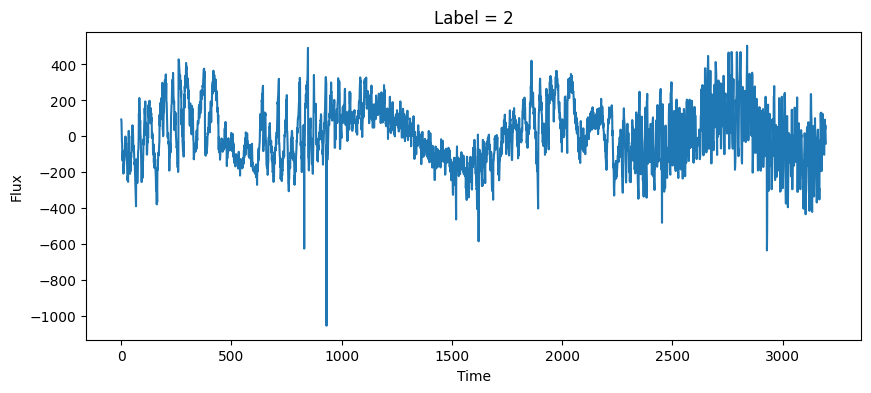

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(X_train[0])
plt.title(f"Label = {y_train[0]}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

#### Mise en forme pour l'ESN

##### Bases

In [8]:
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# Sequences
X_train_seq = [x for x in X_train]
X_test_seq  = [x for x in X_test]

# Verify the shape of X: must be (n, 1)
print(X_train_seq[0].shape)

# Reshape y
y_train_seq = [
    np.full((x.shape[0], 1), y)
    for x, y in zip(X_train_seq, y_train)
]

y_test_seq = [
    np.full((x.shape[0], 1), y)
    for x, y in zip(X_test_seq, y_test)
]

# Verify the shape of y: must be (n, 1)
print(y_train_seq[0].shape)

# Float labels
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Normalisation
mean = np.mean(X_train)
std  = np.std(X_train)

X_train_seq = [(x - mean) / std for x in X_train_seq]
X_test_seq  = [(x - mean) / std for x in X_test_seq]

(3197, 1)
(3197, 1)


##### Paramètres de l'ESN

In [14]:
units = 20
leak_rate = 0.3
input_scaling = 0.5
spectral_radius = 0.9
ridge = 1e-6

### ESN

In [15]:
reservoir = Reservoir(
    units=units,
    lr=leak_rate,
    input_scaling=input_scaling,
    sr=spectral_radius
)

readout = Ridge(ridge=ridge)

esn = reservoir >> readout

#### Entraînement

In [ ]:
# Convert labels in numpy objects
y_train_seq_np = [np.array(y) for y in y_train_seq]
y_test_np = np.array(y_test).astype(int)

# Convert labels 1/2 to 0/1, for "non-exoplanet/exoplanet"
y_train_np = np.array(y_train).astype(int) - 1
y_test_np  = np.array(y_test).astype(int) - 1

# Verification
print(np.unique(y_train_np), np.unique(y_test_np))
# Output: array([0,1]), array([0,1])

# Training
esn.fit(X_train_seq, y_train_seq_np)

# Prediction
y_pred_seq = esn.run(X_test_seq)  # one sequence per entry
y_pred = np.array([yp.mean() for yp in y_pred_seq])  # moyenne pour une décision par série
y_pred_label = (y_pred > 0.5).astype(int)

# Evaluation
accuracy = accuracy_score(y_test_np, y_pred_label)
auc = roc_auc_score(y_test_np, y_pred)

accuracy, auc


(0.9912280701754386, 0.6732743362831859)

1. We have an accuracy of 99%. Mostly all of the test series were classified correctly, but this can be misleading if classes are imbalanced.

2. 0.673 AUC: the model separates classes better than chance, but struggles with the minority class (exoplanets).

### Results Visualization

#### Errors

We can print the real label of the first 10 errors, to see what kind of errors does the ESN make.

Number of errors: 5 on 570


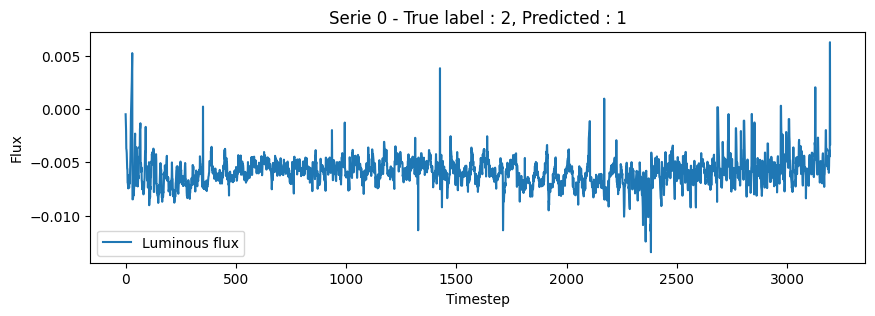

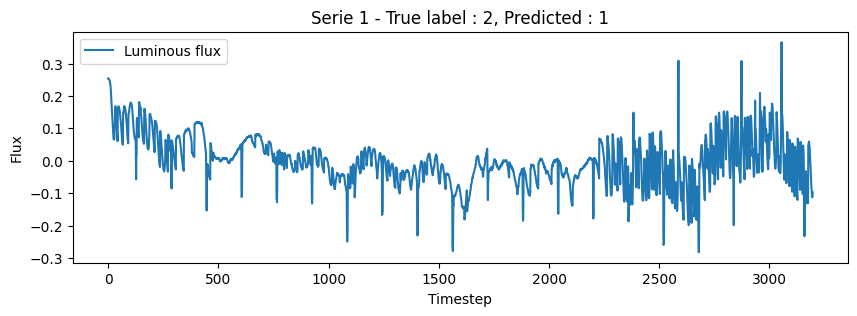

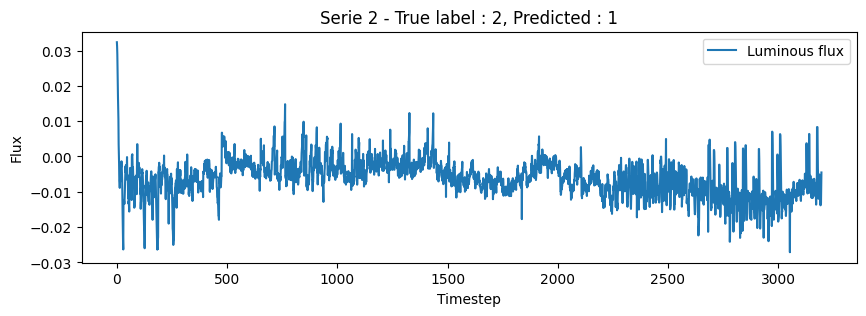

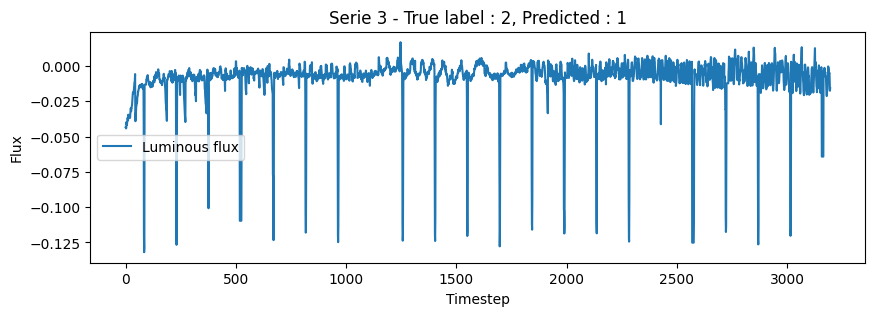

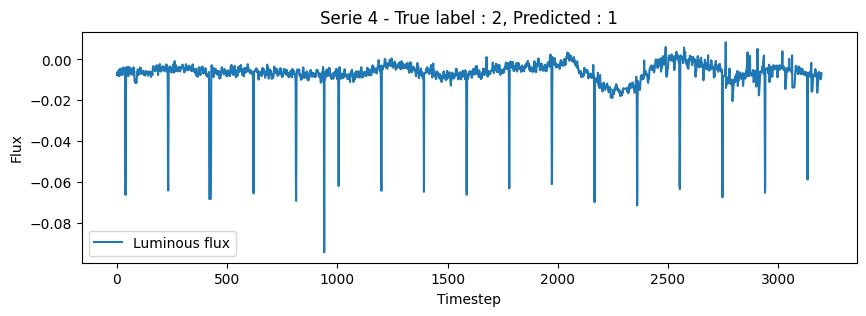

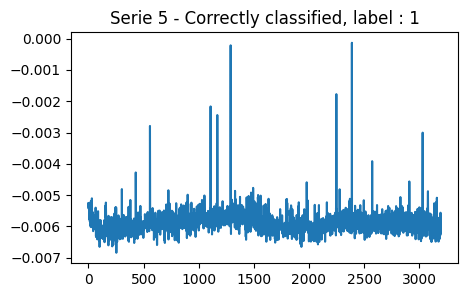

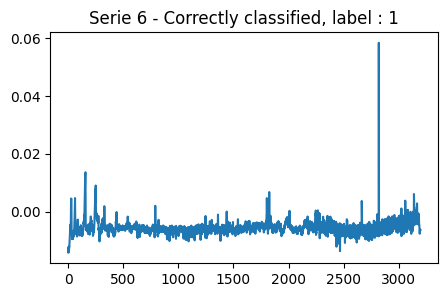

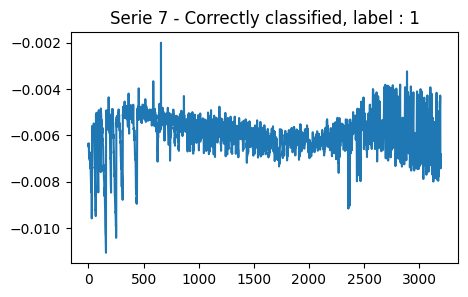

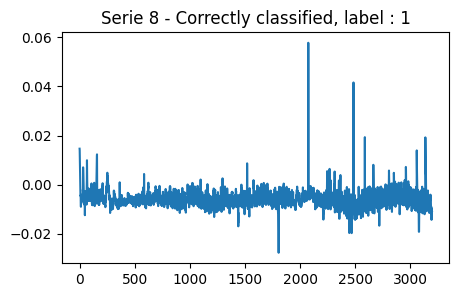

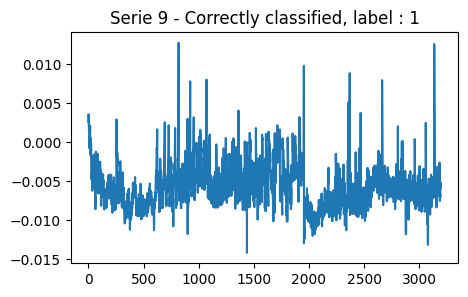

In [20]:
# Errors indices
errors = np.where(y_test_np != y_pred_label)[0]
print(f"Number of errors: {len(errors)} on {len(y_test_np)}")

# Print the 5 first errors
for i in errors[:5]:
    plt.figure(figsize=(10, 3))
    plt.plot(X_test_seq[i].squeeze(), label="Luminous flux")
    plt.title(f"Serie {i} - True label : {y_test_np[i]}, Predicted : {y_pred_label[i]}")
    plt.xlabel("Timestep")
    plt.ylabel("Flux")
    plt.legend()
    plt.show()

# Print the correct labels
correct = np.where(y_test_np == y_pred_label)[0]

for i in correct[:5]:
    plt.figure(figsize=(5, 3))
    plt.plot(X_test_seq[i].squeeze(), label="Luminous flux")
    plt.title(f"Serie {i} - Correctly classified, label : {y_test_np[i]}")
    plt.show()
